<a href="https://colab.research.google.com/github/guciano/Machine-Learning/blob/master/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
uploaded = files.upload()

Saving DataHistorisINDF.csv to DataHistorisINDF.csv


In [3]:
dataframe = pd.read_csv('/content/DataHistorisINDF.csv')
dataframe

In [4]:
dataframe["Tanggal"] = pd.to_datetime(dataframe["Tanggal"]).dt.strftime('%Y-%m-%d')

In [5]:
dataframe

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-10-16,7.075,7.050,7.100,7.000,"10,69M","0,35%"
1,2020-10-15,7.050,7.125,7.150,7.000,"14,58M","-1,05%"
2,2020-10-14,7.125,7.225,7.250,7.100,"10,28M","-1,72%"
3,2020-10-13,7.250,7.225,7.250,7.075,"8,05M","0,69%"
4,2020-12-10,7.200,7.300,7.325,7.200,"5,12M","-0,35%"
...,...,...,...,...,...,...,...
1403,2015-08-01,7.250,7.325,7.350,7.250,"9,45M","-0,34%"
1404,2015-07-01,7.275,7.300,7.350,7.275,"19,63M","-1,36%"
1405,2015-06-01,7.375,7.350,7.475,7.300,"12,16M","-1,34%"
1406,2015-05-01,7.475,7.400,7.500,7.225,"24,21M","0,34%"


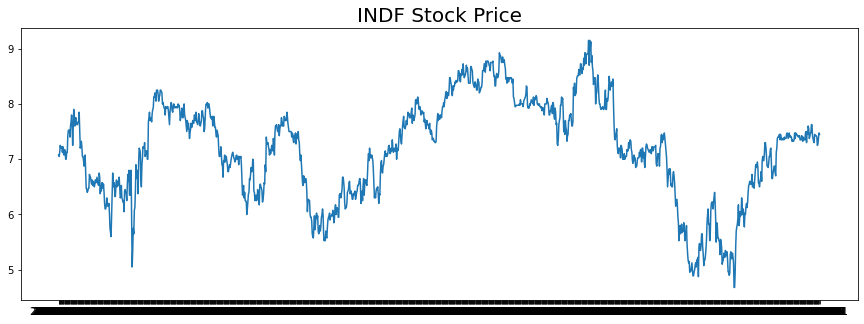

In [6]:
dates = dataframe['Tanggal'].values
price  = dataframe['Terakhir'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('INDF Stock Price',
          fontsize=20);

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
total_size = len(dataframe)
train_set = total_size-int(total_size*0.2)
test_length = total_size-train_set

In [9]:
train_price = windowed_dataset(price[:train_set], window_size=60, batch_size=32, shuffle_buffer=1000)
test_price = windowed_dataset(price[train_set:], window_size=60, batch_size=32, shuffle_buffer=1000)

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [11]:
#Callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.10):
      print("\nWe've Reached %2.2f%% MAE, Stop!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_price,
                    validation_data = test_price,
                    epochs = 500,
                    verbose = 1,
                    callbacks=[callbacks])

Epoch 1/500
34/34 [==============================] - 5s 161ms/step - loss: 6.6391 - mae: 7.1391 - val_loss: 5.4020 - val_mae: 5.9020
Epoch 2/500
34/34 [==============================] - 4s 120ms/step - loss: 6.3575 - mae: 6.8575 - val_loss: 5.1120 - val_mae: 5.6120
Epoch 3/500
34/34 [==============================] - 4s 121ms/step - loss: 6.0134 - mae: 6.5134 - val_loss: 4.7157 - val_mae: 5.2157
Epoch 4/500
34/34 [==============================] - 4s 118ms/step - loss: 5.5062 - mae: 6.0062 - val_loss: 4.0765 - val_mae: 4.5765
Epoch 5/500
34/34 [==============================] - 4s 121ms/step - loss: 4.6873 - mae: 5.1873 - val_loss: 3.0738 - val_mae: 3.5738
Epoch 6/500
34/34 [==============================] - 4s 121ms/step - loss: 3.3755 - mae: 3.8755 - val_loss: 1.4106 - val_mae: 1.8950
Epoch 7/500
34/34 [==============================] - 4s 120ms/step - loss: 1.2924 - mae: 1.7465 - val_loss: 0.6820 - val_mae: 1.0750
Epoch 8/500
34/34 [==============================] - 4s 120ms/step - 

In [ ]:
from matplotlib import style
%matplotlib inline

mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = log_history.history['val_loss']

epochs = range(len(accur))

style.use('ggplot')
plt.figure(figsize=(13, 4))
for j, metrics in enumerate(zip([accur, loss], [val_accur, val_loss], ['MAE', 'Loss'])):
  plt.subplot(1, 2, j + 1)
  plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
  plt.title('Training and Validation {}'.format(metrics[2]))

plt.show()